# Benchmark position-aware graph neural network/2D CNN architecture

This notebook contains all of the code to overfit a GAT to four contact channels of a single structure (6E6O).

## Setup



### Dataloader code 

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import periodictable as pt
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

def read_files(acc, model, graph_dir, contacts_dir):
    """
    Read graph and contacts files.

    Args:
    - acc (str) - String of the PDB ID (lowercese).
    - model (int) - Model number of the desired bioassembly.
    - graph_dir (str) - Directory containing the nodes, edges,
        and mask files.
    - contacts_dir (str) - Directory containing the .contacts
        files from get_contacts.py.

    Returns:
    - Dictionary of DataFrames and lists corresponding to
        graph nodes, edges, mask, and contacts.
    """

    # Get the file names for the graph files
    node_file = os.path.join(graph_dir, '{}-{}_nodes.csv'.format(acc, model))
    edge_file = os.path.join(graph_dir, '{}-{}_edges.csv'.format(acc, model))
    mask_file = os.path.join(graph_dir, '{}-{}_mask.csv'.format(acc, model))

    # Get the contacts file
    contacts_file = os.path.join(contacts_dir, '{}-{}.contacts'.format(acc, model))

    # Read the nodes and edges
    nodes = pd.read_csv(node_file)
    edges = pd.read_csv(edge_file)

    # Check if the mask is empty
    if os.path.getsize(mask_file) > 0:
        with open(mask_file) as f:
            mask = f.read().split('\n')
    else:
        mask = []

    # Read the contacts
    contacts = pd.read_table(contacts_file, sep='\t',
                             header=None, names=['type', 'start', 'end'])

    # Return the data
    data = {
        'nodes': nodes,
        'edges': edges,
        'mask': mask,
        'contacts': contacts
    }

    return data


def process_res_data(data):
    """
    Process residue-level data from atom-level data.

    Args:
    - data (dict) - Dictionary of graph data output from `read_files`.

    Returns:
    - Dictionary of atom and residue graph and contact data.
    """

    # Extract data form dict
    nodes = data['nodes']
    edges = data['edges']
    mask = data['mask']
    contacts = data['contacts']

    # Get residue nodes
    res_nodes = pd.DataFrame()
    res_nodes['res'] = [':'.join(atom.split(':')[:3]) for atom in nodes['atom']]
    res_nodes = res_nodes.drop_duplicates().reset_index(drop=True)

    # Get residue edges
    res_edges = edges.copy()
    res_edges['start'] = [':'.join(atom.split(':')[:3]) for atom in res_edges['start']]
    res_edges['end'] = [':'.join(atom.split(':')[:3]) for atom in res_edges['end']]
    res_edges = res_edges[res_edges['start'] != res_edges['end']].drop_duplicates().reset_index(drop=True)

    # Get residue contacts
    res_contacts = contacts.copy()
    res_contacts['start'] = [':'.join(atom.split(':')[:3]) for atom in res_contacts['start']]
    res_contacts['end'] = [':'.join(atom.split(':')[:3]) for atom in res_contacts['end']]
    res_contacts = res_contacts[res_contacts['start'] != res_contacts['end']].drop_duplicates().reset_index(drop=True)

    # Get residue mask
    res_mask = list(set([':'.join(atom.split(':')[:3]) for atom in mask]))

    # Return data dict
    data = {
        'atom_nodes': nodes,
        'atom_edges': edges,
        'atom_contact': contacts,
        'atom_mask': mask,
        'res_nodes': res_nodes,
        'res_edges': res_edges,
        'res_contact': res_contacts,
        'res_mask': res_mask
    }

    return data


def get_map_dicts(entity_list):
    """
    Map identifiers to indices and vice versa.

    Args:
    - entity_list (list) - List of entities (atoms, residues, etc.)
        to index.

    Returns:
    - Tuple of the entity to index and index to entity dicts, respectively.
    """

    # Create the entity:index dictionary
    ent2idx_dict = {entity: idx for idx, entity in enumerate(entity_list)}

    # Create the index:entity dictionary
    idx2ent_dict = {idx: entity for entity, idx in ent2idx_dict.items()}

    return (ent2idx_dict, idx2ent_dict)


def create_adj_mat(data, dict_map, mat_type):
    """
    Creates an adjacency matrix.

    Args:
    - data (DataFrame) - Dataframe with 'start' and 'end' column
        for each interaction. For atom-level adjacency, 'order'
        column is also required. For atom or residue conatcts,
        'type' column is also required.

    Returns:
    - Coordinate format matrix (numpy). For atom adjacency, third column
        corresponds to bond order. For contacts, third column
        corresponds to channel.

    Channel mappings (shorthand from get_contacts.py source):

        0:
            hp             hydrophobic interactions
        1:
            hb             hydrogen bonds
            lhb            ligand hydrogen bonds
            hbbb           backbone-backbone hydrogen bonds
            hbsb           backbone-sidechain hydrogen bonds
            hbss           sidechain-sidechain hydrogen bonds
            hbls           ligand-sidechain residue hydrogen bonds
            hblb           ligand-backbone residue hydrogen bonds
        2:
            vdw            van der Waals
        3:
            wb             water bridges
            wb2            extended water bridges
            lwb            ligand water bridges
            lwb2           extended ligand water bridges
        4:
            sb             salt bridges
        5:
            ps             pi-stacking
        6:
            pc             pi-cation
        7:
            ts             t-stacking
    """

    # Initialize the coordinate list
    coord_mat = []

    # Map channel names to numeric channels
    channel = {
        # Hydrophobic interactions in first channel
        'hp': 0,

        # Hydrogen bonds in second channel
        'hb': 1,
        'lhb': 1,
        'hbbb': 1,
        'hbsb': 1,
        'hbss': 1,
        'hbls': 1,
        'hblb': 1,

        # VdW in third channel
        'vdw': 2,

        # Water bridges
        'wb': 3,
        'wb2': 3,
        'lwb': 3,
        'lwb2': 3,

        # Salt bridges
        'sb': 4,

        # Other interactions
        'ps': 5,
        'pc': 6,
        'ts': 7,
    }

    # Assemble the contacts
    for idx, row in data.iterrows():

        entry = [dict_map[row['start']], dict_map[row['end']]]

        # Add order or type if necessary
        if mat_type == 'atom_graph':
            entry.append(row['order'])
        elif mat_type == 'atom_contact':
            entry.append(channel[row['type']])
        elif mat_type == 'res_contact':
            entry.append(channel[row['type']])

        coord_mat.append(entry)

    return(np.array(coord_mat))


def create_mem_mat(atom_dict, res_dict):
    """
    Create a membership matrix mapping atoms to residues.

    Args:
    - atom_dict (dict) - Dictionary mapping atoms to indices.
    - res_dict (dict) - Dictionary mapping residues to indices.

    Returns:
    - Coordinate format membership matrix (numpy) with first
        row being residue number and the second column being
        atom number.
    """

    # Initialize the coordinate list
    mem_coord = []

    # Map atoms to residues
    for atom, atom_idx in atom_dict.items():
        res_idx = res_dict[':'.join(atom.split(':')[:3])]

        mem_coord.append([res_idx, atom_idx])

    mem_coord = np.array(mem_coord)

    return mem_coord


def create_idx_list(id_list, dict_map):
    """
    Create list of indices.

    Args:
    - id_list (list) - List of masked atom or residue identifiers.
    - dict_map (dict) - Dictionary mapping entities to indices.

    Returns:
    - A numpy array of the masked indices.
    """

    # Generate the numpy index array
    idx_array = np.array([dict_map[iden] for iden in id_list])

    return idx_array


class TesselateDataset(Dataset):
    """
    Dataset class for structural data.

    Args:
    - accession_list (str) - File path from which to read PDB IDs for dataset.
    - graph_dir (str) - Directory containing the nodes, edges, and mask files.
    - contacts_dir (str) - Directory containing the .contacts files from
        get_contacts.py.
    - return_data (list) - List of datasets to return. Value must be 'all' or
        a subset of the following list:
            - pdb_id
            - model
            - atom_nodes
            - atom_adj
            - atom_contact
            - atom_mask
            - res_adj
            - res_dist
            - res_contact
            - res_mask
            - mem_mat
            - idx2atom_dict
            - idx2res_dict
    """

    def __init__(self, accession_list, graph_dir, contacts_dir, add_covalent=False, return_data='all', in_memory=False):

        if return_data == 'all':
            self.return_data = [
                'pdb_id',
                'model',
                'atom_nodes',
                'atom_adj',
                'atom_contact',
                'atom_mask',
                'res_adj',
                'res_dist',
                'res_contact',
                'res_mask',
                'mem_mat',
                'idx2atom_dict',
                'idx2res_dict'
            ]

        # Store reference to accession list file
        self.accession_list = accession_list

        # Store references to the necessary directories
        self.graph_dir = graph_dir
        self.contacts_dir = contacts_dir

        # Whether to add covalent bonds to prediction task and
        # remove sequence non-deterministic covalent bonds from the adjacency matrix
        self.add_covalent=add_covalent

        # Read in and store a list of accession IDs
        with open(accession_list, 'r') as handle:
            self.accessions = np.array([acc.strip().lower().split() for acc in handle.readlines()])

        self.data = {}


    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
        - Integer count of number of examples.
        """
        return len(self.accessions)


    def __getitem__(self, idx):
        """
        Get an item with a particular index value.

        Args:
        - idx (int) - Index of desired sample.

        Returns:
        - Dictionary of dataset example. All tensors are sparse when possible.
        """
        if idx in self.data:
            return self.data[idx]

        # initialize the return dictionary
        return_dict = {}

        acc_entry = self.accessions[idx]

        # Get the PDB ID
        acc = acc_entry[0]

        # Get the model number if one exists
        if len(acc_entry) == 1:
            model = 1
        else:
            model = acc_entry[1]

        # Read and process the files
        data = read_files(acc, model, self.graph_dir, self.contacts_dir)
        data = process_res_data(data)

        # Generate the mapping dictionaries
        atom2idx_dict, idx2atom_dict = get_map_dicts(data['atom_nodes']['atom'].unique())
        res2idx_dict, idx2res_dict = get_map_dicts(data['res_nodes']['res'].unique())

        # Get numbers of atoms and residues per sample
        n_atoms = len(atom2idx_dict)
        n_res = len(res2idx_dict)

        # Handle all of the possible returned datasets
        if 'pdb_id' in self.return_data:
            return_dict['pdb_id'] = acc

        if 'model' in self.return_data:
            return_dict['model'] = model

        if 'atom_nodes' in self.return_data:
            ele_nums = [pt.elements.symbol(element).number for element in data['atom_nodes']['element']]
            return_dict['atom_nodes'] = torch.LongTensor(ele_nums)

        if 'atom_adj' in self.return_data:
            adj = create_adj_mat(data['atom_edges'], atom2idx_dict, mat_type='atom_graph').T

            x = torch.LongTensor(adj[0, :]).squeeze()
            y = torch.LongTensor(adj[1, :]).squeeze()
            val = torch.FloatTensor(adj[2, :]).squeeze()

            atom_adj = torch.zeros([n_atoms, n_atoms]).index_put_((x, y), val, accumulate=False)

            atom_adj = atom_adj.index_put_((y, x), val, accumulate=False)

            atom_adj[range(n_atoms), range(n_atoms)] = 1

            atom_adj = (atom_adj > 0).float()

            return_dict['atom_adj'] = atom_adj

        if 'atom_contact' in self.return_data:
            atom_contact = create_adj_mat(data['atom_contact'], atom2idx_dict, mat_type='atom_contact').T

            x = torch.LongTensor(atom_contact[0, :]).squeeze()
            y = torch.LongTensor(atom_contact[1, :]).squeeze()
            z = torch.LongTensor(atom_contact[2, :]).squeeze()

            atom_contact = torch.zeros([n_atoms, n_atoms, 8]).index_put_((x, y, z),
                                                                    torch.ones(len(x)))
            atom_contact = atom_contact.index_put_((y, x, z),
                                                   torch.ones(len(x)))

            return_dict['atom_contact'] = atom_contact

        if 'atom_mask' in self.return_data:
            atom_mask = create_idx_list(data['atom_mask'], atom2idx_dict)

            masked_pos = torch.from_numpy(atom_mask)

            if self.add_covalent:
                channels = 9
            else:
                channels = 8

            mask = torch.ones([n_atoms, n_atoms, channels])
            mask[masked_pos, :, :] = 0
            mask[:, masked_pos, :] = 0

            return_dict['atom_mask'] = mask

        if 'res_adj' in self.return_data:
            adj = create_adj_mat(data['res_edges'], res2idx_dict, mat_type='res_graph').T

            x = torch.LongTensor(adj[0, :]).squeeze()
            y = torch.LongTensor(adj[1, :]).squeeze()

            res_adj = torch.zeros([n_res, n_res]).index_put_((x, y), torch.ones(len(x)))

            res_adj = res_adj.index_put_((y, x), torch.ones(len(x)))

            res_adj[range(n_res), range(n_res)] = 1

            return_dict['res_adj'] = res_adj

        if 'res_dist' and 'res_adj' in self.return_data:
            G = nx.from_numpy_matrix(return_dict['res_adj'].numpy())
            res_dist = torch.from_numpy(nx.floyd_warshall_numpy(G)).float()

            return_dict['res_dist'] = res_dist

        if 'res_contact' in self.return_data:
            res_contact = create_adj_mat(data['res_contact'], res2idx_dict, mat_type='res_contact').T

            x = torch.LongTensor(res_contact[0, :]).squeeze()
            y = torch.LongTensor(res_contact[1, :]).squeeze()
            z = torch.LongTensor(res_contact[2, :]).squeeze()

            res_contact = torch.zeros([n_res, n_res, 8]).index_put_((x, y, z),
                                                                    torch.ones(len(x)))

            res_contact = res_contact.index_put_((y, x, z),
                                                 torch.ones(len(x)))

            return_dict['res_contact'] = res_contact

        if 'res_mask' in self.return_data:
            res_mask = create_idx_list(data['res_mask'], res2idx_dict)

            masked_pos = torch.from_numpy(res_mask)

            if self.add_covalent:
                channels = 9
            else:
                channels = 8

            mask = torch.ones([n_res, n_res, channels])
            mask[masked_pos, :, :] = 0
            mask[:, masked_pos, :] = 0

            return_dict['res_mask'] = mask

        if 'mem_mat' in self.return_data:
            mem_mat = create_mem_mat(atom2idx_dict, res2idx_dict).T

            x = torch.LongTensor(mem_mat[0, :]).squeeze()
            y = torch.LongTensor(mem_mat[1, :]).squeeze()

            mem_mat = torch.zeros([n_res, n_atoms]).index_put_((x, y),
                                                               torch.ones(len(x)))

            return_dict['mem_mat'] = mem_mat

        if 'idx2atom_dict' in self.return_data:
            return_dict['idx2atom_dict'] = idx2atom_dict

        if 'idx2res_dict' in self.return_data:
            return_dict['idx2res_dict'] = idx2res_dict

        self.data[idx] = return_dict

        # Return the processed data
        return return_dict

### Modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import itertools as it


####################
# Embedding layers #
####################

class AtomEmbed(nn.Module):
    """
    Embed the atoms to fixed-length input vectors.

    Args:
    - num_features (int) - Size of the returned embedding vectors.
    - scale_grad_by_freq (bool) - Scale gradients by the inverse of
        frequency (default=True).
    """

    def __init__(self, n_features, scale_grad_by_freq=True):
        super(AtomEmbed, self).__init__()
        self.embedding = nn.Embedding(118,
                                      n_features,
                                      scale_grad_by_freq=scale_grad_by_freq)

    def forward(self, atomic_numbers):
        """
        Return the embeddings for each atom in the graph.

        Args:
        - atoms (torch.LongTensor) - Tensor (n_atoms) containing atomic numbers.

        Returns:
        - torch.FloatTensor of dimension (n_atoms, n_features) containing
            the embedding vectors.
        """

        # Get and return the embeddings for each atom
        embedded_atoms = self.embedding(atomic_numbers)
        return embedded_atoms


####################
# Attention layers #
####################

class GraphAttn(nn.Module):
    """
    Graph attention layer.

    Args:
    - in_features (int) - Number of input features.
    - out_features (int) - Number of output features.
    - dropout (bool) - P(keep) for dropout.
    - alpha (float) - Alpha value for leaky ReLU.
    """

    def __init__(self, in_features, out_features, dropout, alpha):
        super(GraphAttn, self).__init__()

        # Parameters
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        # Operations
        self.W = nn.Linear(in_features, out_features, bias=True)
        self.batch_norm_w = nn.BatchNorm1d(out_features)

        self.a = nn.Linear(2*out_features, 1, bias=True)
        self.activation = nn.LeakyReLU(self.alpha)

        self.output_batch_norm = nn.BatchNorm1d(out_features)

    def forward(self, nodes, adj):
        """
        Perform forward pass through graph attention layer.

        Args:
        - nodes (torch.FloatTensor) - Node feature matrix
            (n_nodes, in_features).
        - adj (torch.FloatTensor) - Adjacency matrix (n_nodes, n_nodes).

        Returns:
        - torch.FloatTensor of dimension (n_nodes, n_nodes) of attentional
            coefficients where a_ij is the attention value of for node j with
            respect to node i.
        """

        # Node mat input shape = (n_nodes, out_features)
        node_fts = self.batch_norm_w(self.W(nodes))

        # Number of nodes in graph
        n_nodes = node_fts.size()[0]

        # Concatenate to generate input for attention mechanism
        # (n_nodes, n_nodes, 2*out_features)
        a_input = (torch.cat([node_fts.repeat(1, n_nodes).view(n_nodes *
                                                               n_nodes, -1),
                              node_fts.repeat(n_nodes, 1)], dim=1)
                   .view(n_nodes, n_nodes, 2 * self.out_features))

        # Get the attention logits
        # (n_nodes, n_nodes)
        e = self.activation(self.a(a_input).squeeze(2))

        # Create the mask based on adjacency matrix
        # Clip at 0.5
        mask = adj < 0.5
        e[mask] = float('-inf')

        # Get the attention coefficiencts
        # (n_nodes, n_nodes)
        attention = F.softmax(e, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)

        self.f_attn = attention.detach().cpu()

        output = self.activation(torch.matmul(attention, node_fts))
        output = self.output_batch_norm(output)

        return self.output_batch_norm(output)


class MultiHeadGraphAttn(nn.Module):
    """
    Multi-head graph attention layer.

    Args:
    - n_head (int) - Number of heads for the attention layer.
    - in_features (int) - Number of total input features.
    - out_features (int) - Number of output features per head.
    - dropout (bool) - P(keep) for dropout.
    - alpha (float) - Alpha value for leaky ReLU.
    """

    def __init__(self, n_heads, in_features, out_features, dropout, alpha):
        super(MultiHeadGraphAttn, self).__init__()

        # Parameters
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        # Operations
        heads = [GraphAttn(in_features, out_features, dropout, alpha)
                 for i in range(n_heads)]
        self.attn_heads = nn.ModuleList(heads)

    def forward(self, nodes, adj, cat_dim=1):
        """
        Perform forward pass through multi-head graph attention layer.

        Args:
        - nodes (torch.FloatTensor) - Node feature matrix
            (n_nodes, in_features).
        - adj (torch.FloatTensor) - Adjacency matrix (n_nodes, n_nodes).

        Returns:
        - torch.FloatTensor of dimension (n_nodes, n_nodes) of attentional
            coefficients where a_ij is the attention value of for node j with
            respect to node i.
        """

        if cat_dim == 1:
            vals = torch.cat([head(nodes, adj) for head in self.attn_heads],
                         dim = 1)

        elif cat_dim == -1:
            vals = torch.stack([head(nodes, adj) for head in self.attn_heads])

        return vals


class FCContactPred(nn.Module):
    """
    Fully connected layer to perform contact prediction.

    Args:
    - node_features (int) - Number of input features.
    - out_features (int) - Number of output prediction values.
    """

    def __init__(self, node_features, out_preds, layers=3):
        super(FCContactPred, self).__init__()

        self.linear_first = nn.Linear(node_features, 25, bias=True)

        self.int_layers = nn.ModuleList([nn.Linear(25, 25, bias=True)
                                         for i in range(layers - 2)])

        self.linear_final = nn.Linear(25, out_preds, bias=True)

    def forward(self, combined_nodes):
        """
        Predict pointwise multichannel contacts from summarized pairwise
        residue features.

        Args:
        - nodes (torch.FloatTensor) - Tensor of (convolved) node features
            (n_pairwise, n_features).

        Returns:
        - torch.FloatTensor (n_contacts, n_channels) containing the prediction
            for every potential contact point and every contact channel.
        """
        # Get the logits from the linear layer
        prelogits = self.linear_first(combined_nodes)
        prelogits = F.relu(prelogits)

        for layer in self.int_layers:
            prelogits = layer(prelogits)
            prelogits = F.relu(prelogits)

        logits = self.linear_final(prelogits)

        return logits


class CondenseAttn(nn.Module):
    """
    Graph attention layer.

    Args:
    - in_features (int) - Number of input features.
    - out_features (int) - Number of output features.
    - dropout (bool) - P(keep) for dropout.
    - alpha (float) - Alpha value for leaky ReLU.
    """

    def __init__(self, in_features, out_features, dropout, alpha):
        super(CondenseAttn, self).__init__()

        # Parameters
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        # Operations
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2*out_features, 1, bias=False)
        self.activation = nn.LeakyReLU(self.alpha)

    def forward(self, nodes, adj):
        """
        Perform forward pass through graph attention layer.

        Args:
        - nodes (torch.FloatTensor) - Node feature matrix
            (n_nodes, in_features).
        - adj (torch.FloatTensor) - Adjacency matrix (n_nodes, n_nodes).

        Returns:
        - torch.FloatTensor of dimension (n_nodes, n_nodes) of attentional
            coefficients where a_ij is the attention value of for node j with
            respect to node i.
        """

        # Node mat input shape = (n_nodes, out_features)
        node_fts = self.W(nodes)

        # Number of nodes in graph
        n_nodes = node_fts.size()[0]

        # Concatenate to generate input for attention mechanism
        # (n_nodes, n_nodes, 2*out_features)
        a_input = (torch.cat([node_fts.repeat(1, n_nodes).view(n_nodes *
                                                               n_nodes, -1),
                              node_fts.repeat(n_nodes, 1)], dim=1)
                   .view(n_nodes, n_nodes, 2 * self.out_features))

        # Get the attention logits
        # (n_nodes, n_nodes)
        logits = self.activation(self.a(a_input).squeeze(2))
        logits = torch.matmul(adj, logits)

        # Create the mask based on adjacency matrix
        # Clip at 0.5
        mask = adj < 0.5
        logits[mask] = float('-inf')

        # Get the attention coefficiencts
        # (n_nodes, n_nodes)
        attention = F.softmax(logits, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)

        self.f_attn = attention.detach().cpu()

        return self.activation(torch.matmul(attention, node_fts))


class AttnLinkPredict(nn.Module):
    """
    Multi-head graph attention for link prediction.

    Args:
    - n_layers (int) - Number of layers.
    - n_head (int) - Number of heads for the attention layer.
    - in_features (int) - Number of total input features.
    - out_features (int) - Number of output features per head.
    - dropout (bool) - P(keep) for dropout.
    - alpha (float) - Alpha value for leaky ReLU.
    """

    def __init__(self, n_layers, n_heads, in_features, out_features, dropout, alpha):
        super(AttnLinkPredict, self).__init__()

        # Parameters
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        layers = [MultiHeadGraphAttn(n_heads, in_features,
                                     out_features, dropout,
                                     alpha)]

        layers.extend([MultiHeadGraphAttn(n_heads, n_heads * out_features,
                                     out_features, dropout,
                                     alpha)
                      for i in range(n_layers - 1)])

        self.attn_layers = nn.ModuleList(layers)

        self.attn_batch_norm = nn.BatchNorm1d(n_heads * out_features)

        self.output_linear = nn.Linear(n_heads * out_features, 8)

    def forward(self, nodes, adjacency):

        outputs = []

        for target1, target2 in it.combinations_with_replacement(range(len(nodes)), 2):
            targets = adjacency[[target1, target2], :]

            where = [target1, target2]
            where.extend([ind for ind in np.where(targets.cpu() > 0)[1] if ind not in where])

            out_adj_size = len(where) + 1
            adj = torch.zeros(out_adj_size, out_adj_size)
            adj[[0, 0, 1, 2], [1, 2, 0, 0]] = 1

            neighbors = adjacency[where][:, where]
            adj[1:, 1:] = neighbors

            node_feats = nodes[where]

            node_feats = torch.cat((torch.sum(node_feats[:2], dim=0, keepdim=True), node_feats), dim=0)

            for layer in self.attn_layers:
                node_feats = layer(node_feats, adj)

            outputs.append(node_feats[0, :].unsqueeze(0))

        linear_in = self.attn_batch_norm(torch.cat(outputs, dim=0))

        return self.output_linear(linear_in)



class LinkPredict(nn.Module):
    """
    Multi-head graph attention for link prediction.

    Args:
    - n_layers (int) - Number of layers.
    - n_head (int) - Number of heads for the attention layer.
    - in_features (int) - Number of total input features.
    - out_features (int) - Number of output features per head.
    - dropout (bool) - P(keep) for dropout.
    - alpha (float) - Alpha value for leaky ReLU.
    """

    def __init__(self, n_layers, n_heads, in_features, out_features, dropout, alpha):
        super(AttnLinkPredict, self).__init__()

        # Parameters
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        layers = [MultiHeadGraphAttn(n_heads, in_features,
                                     out_features, dropout,
                                     alpha)]

        layers.extend([MultiHeadGraphAttn(n_heads, n_heads * out_features,
                                     out_features, dropout,
                                     alpha)
                      for i in range(n_layers - 1)])

        self.attn_layers = nn.ModuleList(layers)

        self.attn_batch_norm = nn.BatchNorm1d(n_heads * out_features)

        self.output_linear = nn.Linear(n_heads * out_features, 8)

    def forward(self, nodes, adjacency):

        outputs = []

        for target1, target2 in it.combinations_with_replacement(range(len(nodes)), 2):
            targets = adjacency[[target1, target2], :]

            where = [target1, target2]
            where.extend([ind for ind in np.where(targets.cpu() > 0)[1] if ind not in where])

            out_adj_size = len(where) + 1
            adj = torch.zeros(out_adj_size, out_adj_size)
            adj[[0, 0, 1, 2], [1, 2, 0, 0]] = 1

            neighbors = adjacency[where][:, where]
            adj[1:, 1:] = neighbors

            node_feats = nodes[where]

            node_feats = torch.cat((torch.sum(node_feats[:2], dim=0, keepdim=True), node_feats), dim=0)

            for layer in self.attn_layers:
                node_feats = layer(node_feats, adj)

            outputs.append(node_feats[0, :].unsqueeze(0))

        linear_in = self.attn_batch_norm(torch.cat(outputs, dim=0))

        return self.output_linear(linear_in)

# Functions

In [3]:
import numpy as np
import torch

########################################
# Pairwise matrix generation functions #
########################################

def pairwise_mat(nodes, method='mean'):
    """
    Generate matrix for pairwise determination of interactions.

    Args:
    - nodes (torch.FloatTensor) - Tensor of node (n_nodes, n_features) features.
    - method (str) - One of 'sum' or 'mean' for combination startegy for
        pairwise combination matrix (default = 'mean').

    Returns:
    - torch.FloatTensor of shape (n_pairwise, n_nodes) than can be used used to
        combine feature vectors. Values are 1 if method == "sum" and 0.5 if
        method == "mean".
    """

    # Get the upper triangle indices
    triu = np.vstack(np.triu_indices(nodes.shape[0]))

    # Loop through all indices and add to list with
    idxs = torch.from_numpy(triu).T

    # Convert to tensor
    combos = torch.zeros([idxs.shape[0], nodes.shape[0]]).scatter(1, idxs, 1)

    # Set to 0.5 if method is 'mean'
    if method == 'mean':
        combos *= 0.5

    return combos


####################################
# Pairwise concatenation functions #
####################################

def cat_pairwise(embeddings):

    triu = np.vstack(np.triu_indices(embeddings.shape[0])).T

    node1 = []
    node2 = []

    for i, j in triu:
        node1.append(embeddings[i])
        node2.append(embeddings[j])

    node1 = torch.stack(node1, dim=0)
    node2 = torch.flip(torch.stack(node2, dim=0), dims=(1,))

    return torch.cat((node1, node2), dim=1)


############################
# Upper triangle functions #
############################

def triu_condense(input_tensor):
    """
    Condense the upper triangle of a tensor into a 2d dense representation.

    Args:
    - input_tensor (torch.Tensor) - Tensor of shape (n, n, m).

    Returns:
    - Tensor of shape (n(n+1)/2, m) where elements along the third dimension in
        the original tensor are packed row-wise according to the upper
        triangular indices.
    """

    # Get upper triangle index info
    row_idx, col_idx = np.triu_indices(input_tensor.shape[0])
    row_idx = torch.LongTensor(row_idx)
    col_idx = torch.LongTensor(col_idx)

    # Return the packed matrix
    output = input_tensor[row_idx, col_idx, :]

    return output


def triu_expand(input_matrix):
    """
    Expand a dense representation of the upper triangle of a tensor into
    a 3D squareform representation.

    Args:
    - input_matrix (torch.Tensor) - Tensor of shape (n(n+1)/2, m).

    Returns:
    - Tensor of shape (n, n, m) where elements along the third dimension in the
        original tensor are packed row-wise according to the upper triangular
        indices.
    """
    # Get the edge size n of the tensor
    n_elements = input_matrix.shape[0]
    n_chan = input_matrix.shape[1]
    n_res = int((-1 + np.sqrt(1 + 4 * 2 * (n_elements))) / 2)

    # Get upper triangle index info
    row_idx, col_idx = np.triu_indices(n_res)
    row_idx = torch.LongTensor(row_idx)
    col_idx = torch.LongTensor(col_idx)

    # Generate the output tensor
    output = torch.zeros((n_res, n_res, n_chan))

    # Input the triu values
    for i in range(n_chan):
        i_tens = torch.full((len(row_idx),), i, dtype=torch.long)
        output.index_put_((row_idx, col_idx, i_tens), input_matrix[:, i])

    # Input the tril values
    for i in range(n_chan):
        i_tens = torch.full((len(row_idx),), i, dtype=torch.long)
        output.index_put_((col_idx, row_idx, i_tens), input_matrix[:, i])

    return output

### Model

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class GAT(pl.LightningModule):

    def __init__(self, embed_features, atom_out_features, res_out_features,
                 n_contact_channels, dropout, alpha, train_data, val_data,
                 test_data):
        super(GAT, self).__init__()

        # Properties
        self.embed_features = embed_features
        self.atom_out_features = atom_out_features
        self.res_out_features = res_out_features
        self.n_contact_channels = n_contact_channels
        self.dropout = dropout
        self.alpha = alpha

        # Datasets
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        # Model components
        self.embed = AtomEmbed(embed_features, scale_grad_by_freq=True)

        self.embed_batch_norm = nn.BatchNorm1d(embed_features)

        # Define number of graph conv layers and heads
        n_atom_layers = 5
        n_atom_heads = 3

        n_res_layers = 3
        n_res_heads = 3

        # Set up atom attention
        self.atom_attns = nn.ModuleList([])
        for i in range(n_atom_layers):
            if i == 0:
                attn_layer = MultiHeadGraphAttn(n_atom_heads, embed_features,
                                                atom_out_features,
                                                dropout, alpha)
            else:
                attn_layer = MultiHeadGraphAttn(n_atom_heads,
                                                n_atom_heads * atom_out_features,
                                                atom_out_features,
                                                dropout, alpha)

            self.atom_attns.append(attn_layer)


        # Set up condensation
        self.condense = CondenseAttn(n_atom_heads * atom_out_features,
                                     n_atom_heads * atom_out_features,
                                     dropout, alpha)

        self.condense_batch_norm = nn.BatchNorm1d(n_atom_heads * atom_out_features)

        # Set up res attention
        self.res_attns = nn.ModuleList([])
        for i in range(n_res_layers):
            if i == 0:
                attn_layer = MultiHeadGraphAttn(n_res_heads,
                                                n_atom_heads * atom_out_features,
                                                res_out_features, dropout,
                                                alpha)
            else:
                attn_layer = MultiHeadGraphAttn(n_res_heads,
                                                n_res_heads * res_out_features,
                                                res_out_features, dropout,
                                                alpha)

            self.res_attns.append(attn_layer)

        self.final_attn = MultiHeadGraphAttn(n_res_heads,
                                             n_res_heads * res_out_features,
                                             res_out_features, dropout,
                                             alpha)

        self.activation = nn.LeakyReLU(self.alpha)

#         self.pairwise_batch_norm = nn.BatchNorm1d(n_res_heads * res_out_features * 2)

#         self.pred_contact = FCContactPred(n_res_heads * res_out_features * 2,
#                                           n_contact_channels,
#                                           layers=5)

#         self.pred_contact = AttnLinkPredict(n_layers=3, n_heads=4, in_features=n_res_heads * res_out_features, out_features=10, dropout=0, alpha=0.2)
#         self.pred_contact = GraphAttn(in_features=(n_res_heads*res_out_features)+1, out_features=8, dropout=0, alpha=0.2)

        self.linear_expand = nn.Linear(2, 25)
        self.linear_hidden = nn.Linear(25, 25)
        self.linear_predict = nn.Linear(25, 8)

        self.pred_contact_batch_norm = nn.BatchNorm1d(n_contact_channels)

#         self.expand_mat = nn.Parameter(torch.rand(8, n_res_heads * res_out_features, 10))

#         self.preds_batch_norm = nn.BatchNorm1d(8)

        self.activations = {}

    def forward(self, x):
        atom_embed = self.embed(x['atom_nodes'].squeeze())

        atom_embed_update = self.embed_batch_norm(atom_embed)

        for layer in self.atom_attns:
            atom_embed_update = layer(atom_embed_update, x['atom_adj'].squeeze())

        res_embed = self.condense(atom_embed_update, x['mem_mat'].squeeze())

        res_embed_update = self.condense_batch_norm(res_embed)

        # Do final layer with larger receptive field
        adj = x['res_adj'].squeeze()

        for layer in self.res_attns:
            res_embed_update = layer(res_embed_update, adj)
#             combined = cat_pairwise(res_embed_update)
#             preds = self.pred_contact(combined)
#             adj = torch.sigmoid(triu_expand(preds)[:, :, 1] + x['res_adj'].squeeze())

        res_embed_update = self.final_attn(res_embed_update, adj)

#         print(res_embed_update.shape, res_embed_update.T.shape)

#         combined = res_embed_update

#         preds = torch.bmm(res_embed_update, res_embed_update.permute([0, 2, 1])).permute([1, 2, 0])
        preds = torch.matmul(res_embed_update, res_embed_update.T)
        preds = torch.stack((preds, x['res_dist'].squeeze()), dim=-1)
        preds = triu_condense(preds)
        preds = torch.relu(self.linear_expand(preds))
        preds = torch.relu(self.linear_hidden(preds))
        preds = self.linear_predict(preds)

#         combined = cat_pairwise(res_embed_update)

#         combined = self.pairwise_batch_norm(combined)



        atom_attns = [[head.f_attn for head in layer.attn_heads]
                      for layer in self.atom_attns]
        res_attns = [[head.f_attn for head in layer.attn_heads]
                      for layer in self.res_attns]

#         expanded = torch.matmul(combined, self.expand_mat)
#         unnorm_preds = torch.matmul(expanded, expanded.permute(0, 2, 1)).permute(1, 2, 0)

#         length = unnorm_preds.shape[0]
#         ind = np.diag_indices(length)
#         zeros = torch.ones(length, device=unnorm_preds.device) * -1e3

#         for i in range(unnorm_preds.shape[2]):
#             unnorm_preds[ind[0], ind[1], i] = zeros

#         preds = self.pred_contact(combined, adj)
        preds = self.pred_contact_batch_norm(preds)

        self.activations = {
            'atom_embed': atom_embed.detach().cpu().numpy(),
            'atom_embed_update': atom_embed_update.detach().cpu().numpy(),
            'atom_attn': atom_attns,
            'res_embed': res_embed.detach().cpu().numpy(),
            'res_embed_update': res_embed_update.detach().cpu().numpy(),
            'res_attn': res_attns,
#             'pairwise': pairwise.detach().cpu().numpy(),
#             'combined': combined.detach().cpu().numpy(),
            'preds': preds.detach().cpu().numpy()
        }

        return preds

    def training_step(self, batch, batch_nb):
        # REQUIRED
        y_hat = self.forward(batch).squeeze()
        y = triu_condense(batch['res_contact'].squeeze())
        weights = triu_condense(batch['res_mask'].squeeze())

        return {'loss': F.binary_cross_entropy_with_logits(y_hat, y)}

#     def validation_step(self, batch, batch_nb):
#         # OPTIONAL
# #         x, y = batch
# #         y_hat = self.forward(x)
# #         return {'val_loss': F.cross_entropy(y_hat, y)}
#         pass

#     def validation_end(self, outputs):
#         # OPTIONAL
# #         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
# #         return {'avg_val_loss': avg_loss}
#         pass

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers

        parameters = filter(lambda p: p.requires_grad, self.parameters())

        return torch.optim.SGD(parameters, lr=0.1, momentum=0.9)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(self.train_data, shuffle=True, num_workers=20, pin_memory=True)

#     @pl.data_loader
#     def val_dataloader(self):
#         # OPTIONAL
# #         return DataLoader(), batch_size=32)
#         pass

#     @pl.data_loader
#     def test_dataloader(self):
#         # OPTIONAL
# #         return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)
#         pass

#     def on_batch_end(self):
#         wandb.log({key: plt.imshow(self.activations[key][:20]) for key in self.activations})

#     def training_step(self, batch, batch_nb):
#         y_hat = self.forward(batch)
#         y = triu_condense(batch['res_contact'].squeeze())
#         loss = self.loss(y_hat, y)

#         return {'loss': loss}

#     def configure_optimizers(self):
#         parameters = filter(lambda p: p.requires_grad, self.parameters())
#         return torch.optim.SGD(parameters, lr=1, momentum=0.9)

#     @pl.data_loader
#     def train_dataloader(self):
#         return DataLoader(self.train_data, shuffle=True, num_workers=10, pin_memory=True)

### Analysis functions

In [5]:
def plot_channels(values):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

    ax = ax.flatten()

    channel_names = [
        'Hydrophobic',
        'Hydrogen bond',
        'Van der Waals',
        'Water bridges',
        'Salt bridges',
        'Pi-stacking',
        'Pi-cation',
        'T-stacking'
    ]

    for channel in range(preds.shape[-1]):
        ax[channel].imshow(values[:, :, channel].squeeze(), vmin=0, vmax=1)
        ax[channel].set(title=channel_names[channel], xlabel='Residue #', ylabel='Residue #')

    fig.show()


######################
# ROC and PRC curves #
######################
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def calc_metric_curve(preds, target, curve_type, squareform=False):
    """
    Calculate ROC or PRC curves and area for the predicted contact channels.

    Args:
    - preds (np.ndarray) - Numpy array of model predictions either of form
        (n_res, n_res, n_chan) or (n_res * [n_res - 1] / 2, n_chan).
    - target (np.ndarray) - Numpy array of target values either of form
        (n_res, n_res, n_chan) or (n_res * [n_res - 1] / 2, n_chan),
        must match form of preds.
    - curve_type (str) - One of 'ROC' or 'PRC' to denote type of curve.
    - squareform (bool) - True if tensors are of shape (n_res, n_res, n_chan),
        False if they are of shape (n_res * [n_res - 1] / 2, n_chan)
        (default = True).

    Returns:
    - Tuple of x, y, and AUC values to be used for plotting the curves
        using plot_curve metric.
    """

    # Get correct curve function
    if curve_type.upper() == 'ROC':
        curve_func = roc_curve
    elif curve_type.upper() == 'PRC':
        curve_func = precision_recall_curve

    # Generate dicts to hold outputs from curve generation functions
    x = dict()
    y = dict()
    auc_ = dict()

    # Handle case of squareform matrix (only get non-redundant triu indices)
    if squareform:
        indices = np.triu_indices(target.shape[0])

    # For each channel
    for i in range(target.shape[-1]):

        # Handle case of squareform
        if squareform:
            var1, var2, _ = curve_func(target[:, :, i][indices],
                                       preds[:, :, i][indices])

        # Handle case of pairwise
        else:
            var1, var2, _ = curve_func(target[:, i], preds[:, i])

        # Assign outputs to correct dict for plotting
        if curve_type.upper() == 'ROC':
            x[i] = var1
            y[i] = var2
        elif curve_type.upper() == 'PRC':
            x[i] = var2
            y[i] = var1

        # Calc AUC
        auc_[i] = auc(x[i], y[i])

    return (x, y, auc_)


def plot_curve_metric(x, y, auc, curve_type, title=None, labels=None):
    """
    Plot ROC or PRC curves per output channel.

    Args:
    - x (dict) - Dict of numpy arrays for values to plot on x axis.
    - y (dict) - Dict of numpy arrays for values to plot on x axis.
    - auc (dict) - Dict of numpy arrays for areas under each curve.
    - curve_type (str) - One of 'ROC' or 'PRC' to denote type of curve.
    - title
    - labels

    Returns:
    - pyplot object of curves.
    """

    # Generate figure
    plt.figure()

    # Linetype spec
    lw = 2
    curve_type = curve_type.upper()

    # Get the number of channels being plotted
    n_chan = len(x)

    # Make labels numeric if not provided
    if labels is None:
        labels = list(range(n_chan))

    # Check to make sure the labels are the right length
    if len(labels) != n_chan:
        raise ValueError('Number of labels ({}) does not match number of prediction channels ({}).'.format(len(labels), n_chan))

    # Get a lit of colors for all the channels
    color_list = plt.cm.Set1(np.linspace(0, 1, n_chan))

    # Plot each line
    for i, color in enumerate(color_list):
        plt.plot(x[i], y[i], color=color,
                 lw=lw, label='{} (area = {:0.2f})'.format(labels[i], auc[i]))

    # Add labels and diagonal line for ROC
    if curve_type == 'ROC':
        xlab = 'FPR'
        ylab = 'TPR'
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.legend(loc="lower right")

    # Add labels for PRC
    elif curve_type == 'PRC':
        xlab = 'Recall'
        ylab = 'Precision'
        plt.legend(loc="lower left")

    # Extend limits, add labels and title
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    if title is not None:
        plt.title('{} for {}'.format(curve_type, title))
    else:
        plt.title('{}'.format(curve_type))

    plt.show()

def plot_curve(preds, target, curve_type, title=None, labels=None,
               squareform=False):
    """
    Wrapper to directly plot curves from model output and target.

    Args:
    - preds (np array-like) - Array or tensor of predicted values output by
        model.
    - target (np array-like) - Array or tensor of target values.
    - curve_type (str) - One of 'ROC' or 'PRC'.
    - title (str) - Title of plot (default = None).
    - labels (list) - List of labels for each channel on the plot
        (default = None).
    - squareform (bool) - Whether the predictions and targets are in square form
        (default = False).
    """
    x, y, auc_ = calc_metric_curve(preds, target, curve_type, squareform)
    return plot_curve_metric(x, y, auc_, curve_type, title, labels)

## Training

### Instantiate dataloader and model

In [6]:
data_base = '/home/tshimko/tesselate/'

torch.manual_seed(0)


train_data = TesselateDataset(data_base + 'test2.txt', graph_dir=data_base + 'data/graphs',
                             contacts_dir=data_base + 'data/contacts',
                              return_data='all', in_memory=True)

model = GAT(embed_features=10, atom_out_features=10, res_out_features=10,
             n_contact_channels=8, dropout=0, alpha=0.2, train_data=train_data, val_data=None,
             test_data=None)

In [7]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=15000, checkpoint_callback=False, early_stop_callback=False, gpus=1)
trainer.fit(model)

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                        Name                Type Params
0                      embed           AtomEmbed    1 K
1            embed.embedding           Embedding    1 K
2           embed_batch_norm         BatchNorm1d   20  
3                 atom_attns          ModuleList    4 K
4               atom_attns.0  MultiHeadGraphAttn  513  
..                       ...                 ...    ...
190               activation           LeakyReLU    0  
191            linear_expand              Linear   75  
192            linear_hidden              Linear  650  
193           linear_predict              Linear  208  
194  pred_contact_batch_norm         BatchNorm1d   16  

[195 rows x 3 columns]


Epoch 15000: 100%|██████████| 1/1 [00:01<00:00,  1.12s/batch, batch_idx=0, gpu=0, loss=0.003, v_num=75]


1

# Analysis

In [8]:
acts = model.activations
x = train_data[0]

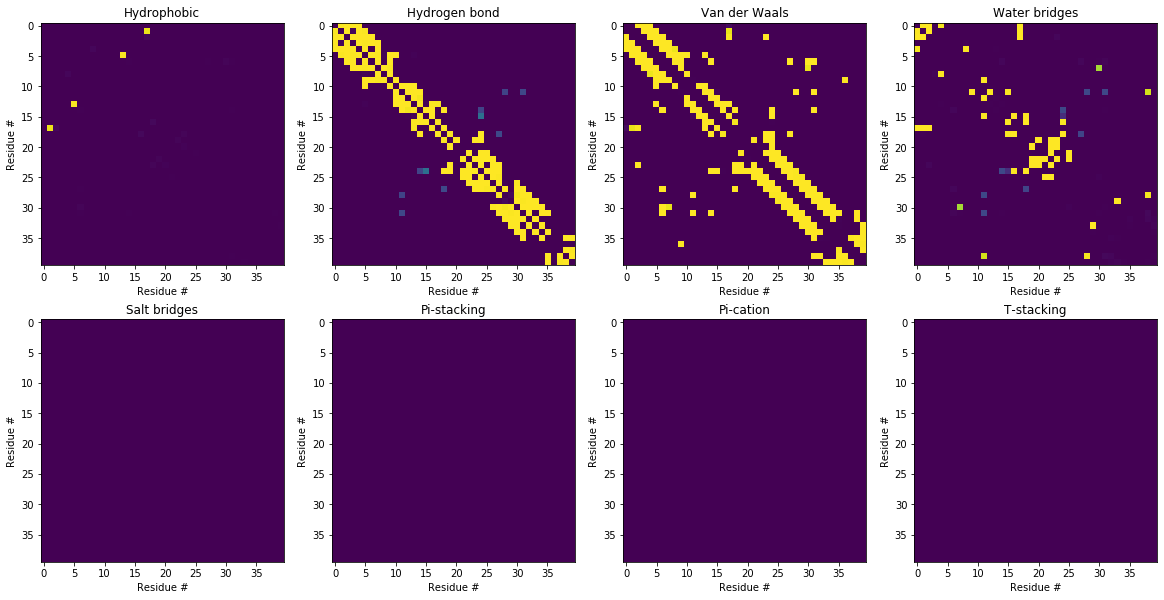

In [9]:
# Plot the predictions
preds = triu_expand(torch.from_numpy(acts['preds'])).sigmoid()
plot_channels(preds)

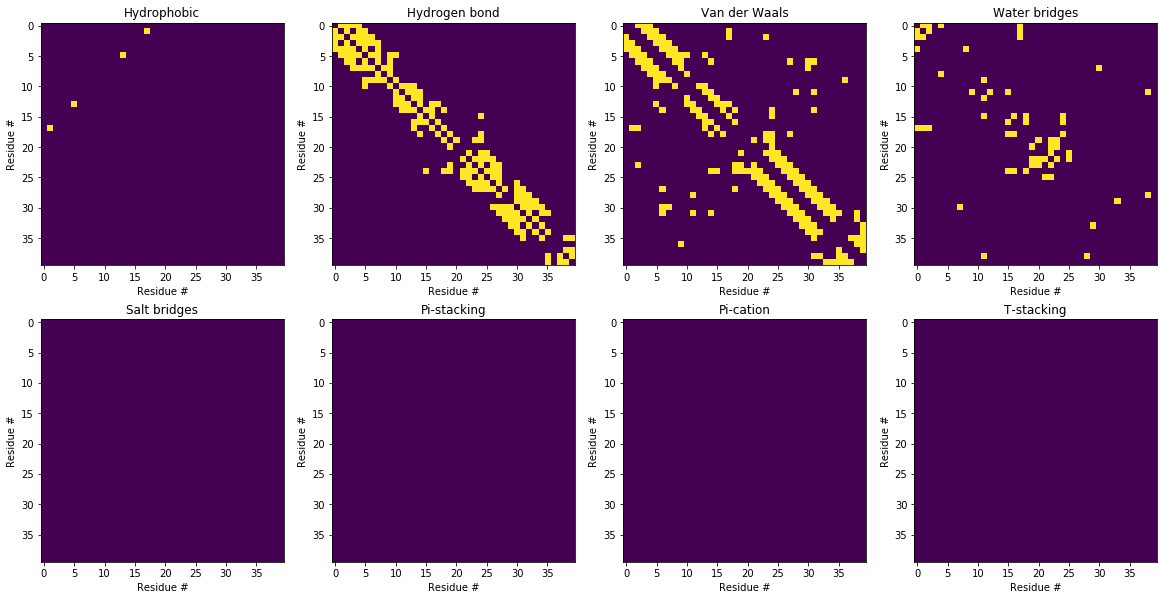

In [10]:
# Plot the true values
plot_channels(x['res_contact'])

## ROC

/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


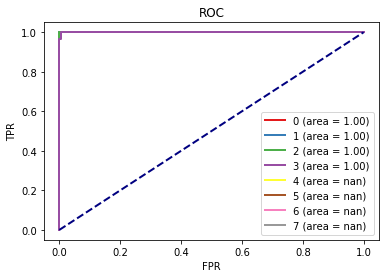

In [11]:
plot_curve(torch.from_numpy(acts['preds']).sigmoid(), triu_condense(x['res_contact'].squeeze()), 'ROC')

## PRC

/home/tshimko/.virtualenvs/tesselate/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


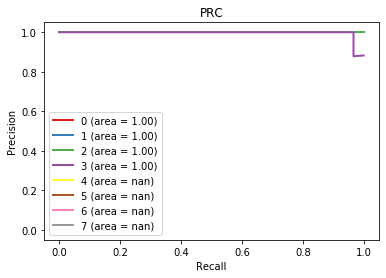

In [12]:
plot_curve(torch.from_numpy(acts['preds']).sigmoid(), triu_condense(x['res_contact'].squeeze()), 'PRC')